## Final Results and Model
Author: Ewan Long, Anne Tumlin 

Date: 04/13/25

Based on our findings in `ModelComparison.ipynb`, linear regression consistently outperformed more complex models such as decision trees, random forests, and XGBoost. In this notebook, we explore whether we can further enhance linear regression performance through advanced techniques like feature transformations and regularization.

In [1]:
import os
import subprocess
import time
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import col, explode, input_file_name, expr, sum as spark_sum, avg, count


spark = (
    SparkSession.builder
    .config("spark.dynamicAllocation.enabled", "false")
    .getOrCreate()
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/13 22:23:53 INFO SparkEnv: Registering MapOutputTracker
25/04/13 22:23:53 INFO SparkEnv: Registering BlockManagerMaster
25/04/13 22:23:53 INFO SparkEnv: Registering BlockManagerMasterHeartbeat
25/04/13 22:23:53 INFO SparkEnv: Registering OutputCommitCoordinator


In [2]:
df = spark.read.parquet("gs://ds5460-tumlinam-fp-bucket/final_datasets/combined_features_df/")

### Vanilla Linear Regression
Let's start by getting the baseline for an LR model to compare against as we tune and try to get better results. 

In [3]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
import time
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml import Pipeline

In [4]:
feature_cols = [c for c in df.columns if c != "filename" and c != "total_cost"]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="raw_features")
assembled_df = assembler.transform(df).select("raw_features", col("total_cost").alias("label"))

In [40]:
scaler = StandardScaler(inputCol="raw_features", outputCol="features", withMean=True, withStd=True)
scaler_model = scaler.fit(assembled_df)
scaled_df = scaler_model.transform(assembled_df).select("features", "label")

In [7]:
train_data, test_data = scaled_df.randomSplit([0.8, 0.2], seed=42)

In [ ]:
lr = LinearRegression(featuresCol="features", labelCol="label")
start_time = time.time()
lr_model = lr.fit(train_data)
train_time = time.time() - start_time

In [9]:
predictions = lr_model.transform(test_data)
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction")

rmse = evaluator.evaluate(predictions, {evaluator.metricName: "rmse"})
mae = evaluator.evaluate(predictions, {evaluator.metricName: "mae"})
r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})

print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"R²:   {r2:.4f}")
print(f"Training Time: {train_time:.2f} seconds")

RMSE: 280.7658
MAE:  220.6687
R²:   0.9983
Training Time: 35.84 seconds


### Ridge Regression
So, for a vanilla LR we are getting an RMSE of 280.7658. Let's try **Ridge Regression**. 

In [11]:
ridge = LinearRegression(featuresCol="features", labelCol="label", elasticNetParam=0.0)

paramGrid = (ParamGridBuilder()
    .addGrid(ridge.regParam, [0.001, 0.01, 0.1, 1.0])
    .build())

evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")

In [12]:
tvs = TrainValidationSplit(estimator=ridge,
                           estimatorParamMaps=paramGrid,
                           evaluator=evaluator,
                           trainRatio=0.8)

In [13]:
start_time = time.time()
ridge_model = tvs.fit(train_data)
train_time = time.time() - start_time

In [14]:
predictions = ridge_model.transform(test_data)
rmse = evaluator.evaluate(predictions, {evaluator.metricName: "rmse"})
mae = evaluator.evaluate(predictions, {evaluator.metricName: "mae"})
r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})

print("Best regParam:", ridge_model.bestModel._java_obj.getRegParam())
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"R²:   {r2:.4f}")
print(f"Training Time: {train_time:.2f} seconds")

Best regParam: 0.01
RMSE: 280.8556
MAE:  220.5700
R²:   0.9983
Training Time: 57.11 seconds


### Lasso Regression
Not much better improvement but still on par. Let's try **Lasso**. 

In [15]:
lasso = LinearRegression(labelCol="label", featuresCol="features", elasticNetParam=1.0)

paramGrid = ParamGridBuilder() \
    .addGrid(lasso.regParam, [0.01, 0.1, 1.0]) \
    .build()

In [16]:
tvs = TrainValidationSplit(estimator=lasso,
                           estimatorParamMaps=paramGrid,
                           evaluator=RegressionEvaluator(labelCol="label"),
                           trainRatio=0.8)

In [17]:
start_time = time.time()
lasso_model = tvs.fit(train_data)
train_time = time.time() - start_time

In [18]:
predictions = lasso_model.transform(test_data)
rmse = evaluator.evaluate(predictions, {evaluator.metricName: "rmse"})
mae = evaluator.evaluate(predictions, {evaluator.metricName: "mae"})
r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})

print(f"Lasso RMSE: {rmse:.4f}")
print(f"Lasso MAE:  {mae:.4f}")
print(f"Lasso R²:   {r2:.4f}")
print(f"Training Time: {train_time:.2f} seconds")

Lasso RMSE: 293.5459
Lasso MAE:  228.4136
Lasso R²:   0.9982
Training Time: 45.86 seconds


### ElasticNet
Lasso actually made the model perform worse. Let's try **ElasticNet**. 

In [19]:
en = LinearRegression(featuresCol="features", labelCol="label")

paramGrid = (ParamGridBuilder()
             .addGrid(en.regParam, [0.01, 0.1, 1.0])
             .addGrid(en.elasticNetParam, [0.1, 0.5, 0.9])
             .build())

evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")

tvs = TrainValidationSplit(estimator=en,
                           estimatorParamMaps=paramGrid,
                           evaluator=evaluator,
                           trainRatio=0.8)

In [20]:
start_time = time.time()
en_model = tvs.fit(train_data)
train_time = time.time() - start_time

In [21]:
predictions = en_model.transform(test_data)
rmse = evaluator.evaluate(predictions, {evaluator.metricName: "rmse"})
mae = evaluator.evaluate(predictions, {evaluator.metricName: "mae"})
r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})

print(f"Best regParam: {en_model.bestModel._java_obj.getRegParam()}")
print(f"Best elasticNetParam: {en_model.bestModel._java_obj.getElasticNetParam()}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"R²:   {r2:.4f}")
print(f"Training Time: {train_time:.2f} seconds")

Best regParam: 0.01
Best elasticNetParam: 0.1
RMSE: 293.4881
MAE:  228.3783
R²:   0.9982
Training Time: 52.55 seconds


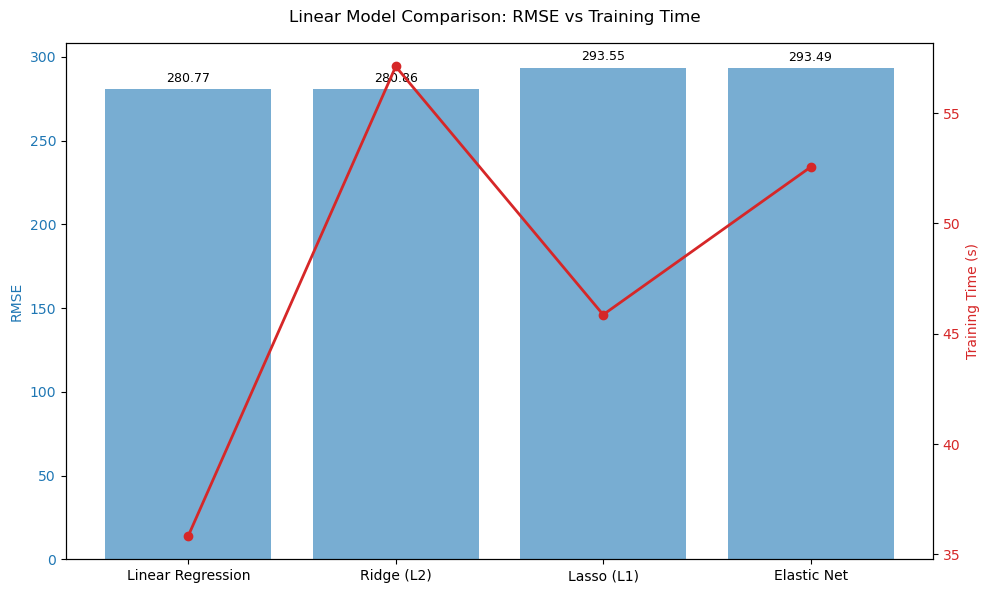

In [24]:
import matplotlib.pyplot as plt
import pandas as pd

data = {
    "Model": ["Linear Regression", "Ridge (L2)", "Lasso (L1)", "Elastic Net"],
    "RMSE": [280.77, 280.86, 293.55, 293.49],
    "MAE": [220.67, 220.57, 228.41, 228.38],
    "R2": [0.9983, 0.9983, 0.9982, 0.9982],
    "Training Time": [35.84, 57.11, 45.86, 52.55]
}

df_plot = pd.DataFrame(data)

fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
bars = ax1.bar(df_plot["Model"], df_plot["RMSE"], alpha=0.6, label="RMSE", color=color)
ax1.set_ylabel('RMSE', color=color)
ax1.tick_params(axis='y', labelcolor=color)

for bar in bars:
    height = bar.get_height()
    ax1.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3), textcoords="offset points",
                 ha='center', va='bottom', fontsize=9, color='black')

ax2 = ax1.twinx()
color = 'tab:red'
ax2.plot(df_plot["Model"], df_plot["Training Time"], color=color, marker='o', label="Training Time", linewidth=2)
ax2.set_ylabel('Training Time (s)', color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.suptitle("Linear Model Comparison: RMSE vs Training Time")
plt.tight_layout()
plt.show()


### Linear Regression Method Comparison

While **Vanilla LR** achieved the lowest RMSE and highest R², the **Ridge Regression** model demonstrated nearly identical performance with slightly improved MAE, suggesting that minor regularization can help stabilize predictions. **Lasso** and **Elastic Net** underperformed slightly, likely due to their biasing effect on coefficients. 


### Polynomial Feature Expansion

The **Polynomial Regression** model’s results will offer insight into whether incorporating interactions adds predictive value beyond linear relationships.

In [7]:
from pyspark.ml.feature import PolynomialExpansion

In [59]:
assembler = VectorAssembler(inputCols=feature_cols, outputCol="raw_features")

scaler = StandardScaler(inputCol="raw_features", outputCol="features", withMean=True, withStd=True)

In [60]:
polyExpansion = PolynomialExpansion(degree=3, inputCol="features", outputCol="poly_features")

poly_lr = LinearRegression(featuresCol="poly_features", labelCol="label")

pipeline = Pipeline(stages=[assembler, scaler, polyExpansion, poly_lr])

In [61]:
df_labeled = df.select(*feature_cols, col("total_cost").alias("label"))
train_data, test_data = df_labeled.randomSplit([0.8, 0.2], seed=42)

In [62]:
start_time = time.time()
model = pipeline.fit(train_data)
train_time = time.time() - start_time

25/04/13 21:28:49 WARN Instrumentation: [40cc2be2] regParam is zero, which might cause numerical instability and overfitting.
25/04/13 21:28:58 WARN Instrumentation: [40cc2be2] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


In [63]:
predictions = model.transform(test_data)
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction")
rmse = evaluator.setMetricName("rmse").evaluate(predictions)
mae = evaluator.setMetricName("mae").evaluate(predictions)
r2 = evaluator.setMetricName("r2").evaluate(predictions)

print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"R²:   {r2:.4f}")
print(f"Training Time: {train_time:.2f} seconds")

RMSE: 247.8984
MAE:  197.4194
R²:   0.9987
Training Time: 32.65 seconds


### Polynomial Feature Expansion + Ridge Regression

In [64]:
ridge = LinearRegression(featuresCol="poly_features", labelCol="label", regParam=0.1)

pipeline = Pipeline(stages=[assembler, scaler, polyExpansion, ridge])

paramGrid = ParamGridBuilder().addGrid(ridge.regParam, [0.01, 0.05, 0.1, 0.5]).build()

tvs = TrainValidationSplit(
    estimator=pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    trainRatio=0.8
)

In [65]:
start_time = time.time()
ridge_model = tvs.fit(train_data)
train_time = time.time() - start_time

In [66]:
preds = ridge_model.transform(test_data)
rmse = evaluator.evaluate(preds, {evaluator.metricName: "rmse"})
mae = evaluator.evaluate(preds, {evaluator.metricName: "mae"})
r2 = evaluator.evaluate(preds, {evaluator.metricName: "r2"})

print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"R²:   {r2:.4f}")
print(f"Training Time: {train_time:.2f} seconds")

RMSE: 247.2876
MAE:  197.2411
R²:   0.9987
Training Time: 58.59 seconds


Given that our experiments from `ModelComparison.ipynb` showed linear regression outperforming more complex models like random forests, gradient boosted trees, and even XGBoost, we hypothesized that the relationship between features and total generation cost might still be predominantly linear — but with some nonlinear interactions that basic linear models couldn't capture directly. To explore this, we introduced polynomial feature expansion, which allows the linear model to incorporate pairwise feature interactions without sacrificing interpretability or efficiency. This approach significantly improved performance, reducing RMSE by over 30 points compared to the baseline, and confirmed that capturing higher-order feature relationships was key to improving predictions on this task. The best-performing model, Ridge Regression with polynomial features, achieved an RMSE of **247.28** (down from **280.77**), affirming that the combination of linear modeling and engineered nonlinearity struck the right balance between complexity and generalization.

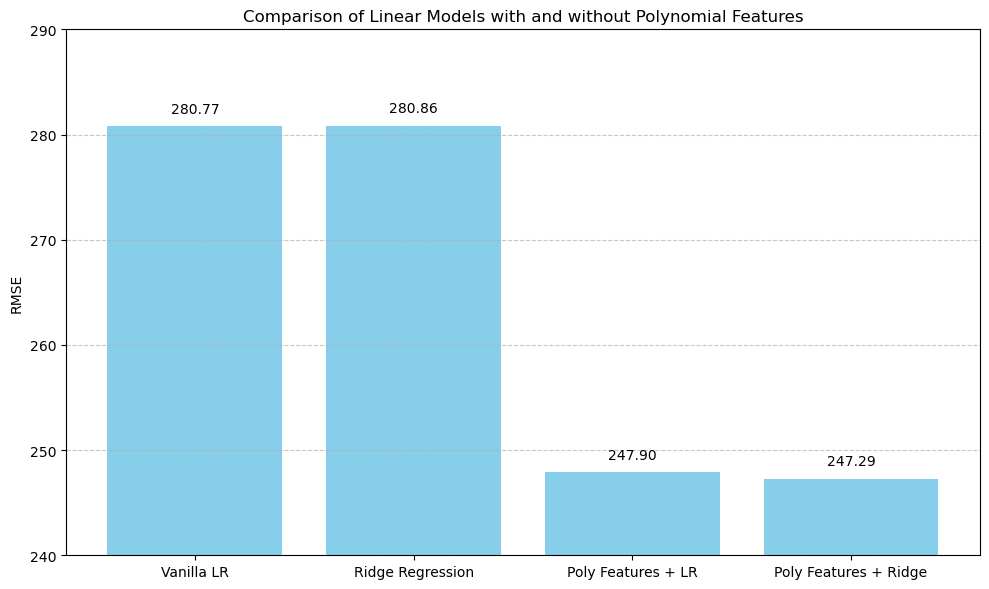

In [67]:
data = {
    "Model": [
        "Vanilla LR", 
        "Ridge Regression", 
        "Poly Features + LR", 
        "Poly Features + Ridge"
    ],
    "RMSE": [
        280.7658,    # Vanilla Linear Regression
        280.8556,    # Ridge
        247.8984,    # Polynomial + Vanilla LR
        247.2876     # Polynomial + Ridge
    ]
}

df_plot = pd.DataFrame(data)

plt.figure(figsize=(10, 6))
bars = plt.bar(df_plot["Model"], df_plot["RMSE"], color='skyblue')

# Annotate bars with RMSE values
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f"{yval:.2f}", ha='center', va='bottom', fontsize=10)

plt.title("Comparison of Linear Models with and without Polynomial Features")
plt.ylabel("RMSE")
plt.ylim(240, 290)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Bagging and Boosting
Now, let's explore **bagging and boosting techniques** to assess whether ensemble methods can further improve predictive accuracy and robustness compared to individual models.

**Bagging Methods:**

In [5]:
# Import the libraries if you run the code from here directly
from pyspark.ml.feature import VectorAssembler
import time
from pyspark.ml.regression import LinearRegression
from pyspark.sql.functions import monotonically_increasing_id, col, expr
from pyspark.ml.evaluation import RegressionEvaluator

In [70]:
assembler = VectorAssembler(inputCols=feature_cols, outputCol="raw_features")
assembled_df = assembler.transform(df).select("raw_features", col("total_cost").alias("label"))

poly = PolynomialExpansion(degree=2, inputCol="raw_features", outputCol="poly_features")
poly_df = poly.transform(assembled_df)

scaler = StandardScaler(inputCol="poly_features", outputCol="features", withMean=True, withStd=True)
scaler_model = scaler.fit(poly_df)
scaled_df = scaler_model.transform(poly_df).select("features", "label")

In [71]:
train_data, test_data = scaled_df.randomSplit([0.8, 0.2], seed=42)

In [73]:
# Model Training
# Set the number of Bagging models to train
n_models = 10

# Lists to store trained models and individual training times
models = []
training_times = []

print("Starting training of Bagging models...")

for i in range(n_models):
    # Generate a bootstrap sample (with replacement) from the training set
    train_sample = train_data.sample(withReplacement=True, fraction=1.0, seed=i)
    
    # Define a simple linear regression model
    lr = LinearRegression(regParam=0.01,featuresCol="features", labelCol="label")
    
    # Record training time
    start_time = time.time()
    model = lr.fit(train_sample)
    end_time = time.time()
    
    models.append(model)
    model_time = end_time - start_time
    training_times.append(model_time)
    print(f"Model {i} training time: {model_time:.4f} seconds")

# Calculate the total training time for all models
total_training_time = sum(training_times)
print(f"Total training time: {total_training_time:.4f} seconds")


Starting training of Bagging models...


Model 0 training time: 19.7574 seconds


Model 1 training time: 18.6292 seconds


Model 2 training time: 17.9837 seconds


Model 3 training time: 17.9903 seconds


Model 4 training time: 17.9267 seconds


Model 5 training time: 17.7316 seconds


Model 6 training time: 17.5716 seconds


Model 7 training time: 18.1033 seconds


Model 8 training time: 17.8723 seconds


Model 9 training time: 17.9566 seconds
Total training time: 181.5225 seconds


In [74]:
# Add a unique identifier to the test set for later joining predictions
test_data_with_id = test_data.withColumn("id", monotonically_increasing_id())

# Create a DataFrame with the unique id and true label
preds_df = test_data_with_id.select("id", "label")

# For each trained model, generate predictions on the test set and join with preds_df
for idx, model in enumerate(models):
    # Obtain predictions and rename the "prediction" column to "pred_{idx}"
    pred = model.transform(test_data_with_id).select("id", col("prediction").alias(f"pred_{idx}"))
    preds_df = preds_df.join(pred, on="id")

# Calculate the ensemble prediction by averaging the predictions from all models
pred_cols = [f"pred_{i}" for i in range(n_models)]
# Build an expression that sums all prediction columns
sum_expr = " + ".join(pred_cols)
preds_df = preds_df.withColumn("ensemble_prediction", (expr(sum_expr)) / n_models)

In [75]:
# Create evaluators for RMSE, MAE, and R² metrics using the ensemble prediction
evaluator_rmse = RegressionEvaluator(labelCol="label", predictionCol="ensemble_prediction", metricName="rmse")
evaluator_mae = RegressionEvaluator(labelCol="label", predictionCol="ensemble_prediction", metricName="mae")
evaluator_r2  = RegressionEvaluator(labelCol="label", predictionCol="ensemble_prediction", metricName="r2")

# Evaluate the metrics on the ensemble predictions
rmse = evaluator_rmse.evaluate(preds_df)
mae = evaluator_mae.evaluate(preds_df)
r2  = evaluator_r2.evaluate(preds_df)

# Print the evaluation metrics and total training time
print("----- Evaluation Metrics for Bagging Ensemble with Simple Linear Regression -----")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"R²:   {r2:.4f}")
print(f"Total training time: {total_training_time:.4f} seconds")

----- Evaluation Metrics for Bagging Ensemble with Simple Linear Regression -----
RMSE: 247.2926
MAE:  197.3617
R²:   0.9987
Total training time: 181.5225 seconds


**Boosting Methods**

In [8]:
assembler = VectorAssembler(inputCols=feature_cols, outputCol="raw_features")
df_assembled = assembler.transform(df).select("raw_features", col("total_cost").alias("label"))

# Add polynomial features
poly_expand = PolynomialExpansion(degree=2, inputCol="raw_features", outputCol="features")
df_poly = poly_expand.transform(df_assembled).select("features", "label")

# Split and add IDs
train_data, test_data = df_poly.randomSplit([0.8, 0.2], seed=42)
train_data = train_data.withColumn("id", monotonically_increasing_id())
test_data = test_data.withColumn("id", monotonically_increasing_id())

In [9]:
from pyspark.sql.functions import lit, mean

# Compute initial prediction f0: the mean of the training label
f0 = train_data.agg(mean("label")).first()[0]

# Initialize training DataFrame with initial prediction column "f"
boosted_train = train_data.withColumn("f", lit(f0))
boosted_train.cache()

DataFrame[features: vector, label: double, id: bigint, f: double]

In [10]:
# Set boosting parameters
num_iterations = 6         # Number of boosting iterations
learning_rate = 0.01         # Learning rate (shrinkage factor)
models_boost = []           # List to store each boosting model
training_times = []         # List to record training time per iteration

print("Starting boosting training...")

for i in range(num_iterations):
    # Compute the residual: residual = label - current prediction f
    boosted_train = boosted_train.withColumn("residual", col("label") - col("f"))
    
    # Train a simple linear regression model to fit the residuals
    lr = LinearRegression(regParam=0.01,featuresCol="features", labelCol="residual")
    start_time = time.time()
    model = lr.fit(boosted_train)
    iter_time = time.time() - start_time
    training_times.append(iter_time)
    models_boost.append(model)
    print(f"Iteration {i} training time: {iter_time:.4f} seconds")
    
    # Obtain the model's prediction (delta) on the training set
    preds = model.transform(boosted_train).select("id", col("prediction").alias("delta"))
    
    # Update the prediction column "f": new f = old f + learning_rate * delta
    boosted_train = boosted_train.join(preds, on="id") \
                                 .withColumn("f", col("f") + lit(learning_rate) * col("delta")) \
                                 .drop("delta", "residual")

total_training_time = sum(training_times)
print(f"Total boosting training time: {total_training_time:.4f} seconds")


Starting boosting training...


Iteration 0 training time: 18.0992 seconds


Iteration 1 training time: 5.4210 seconds


Iteration 2 training time: 8.8737 seconds


Iteration 3 training time: 12.5681 seconds


Iteration 4 training time: 14.0197 seconds


Iteration 5 training time: 17.2661 seconds
Total boosting training time: 76.2478 seconds


In [11]:
from pyspark.sql.functions import monotonically_increasing_id

# Initialize test predictions with the same constant f0 computed from training
boosted_test = test_data.withColumn("f", lit(f0))

# Iteratively update the test predictions with each boosting model
for model in models_boost:
    preds = model.transform(boosted_test).select("id", col("prediction").alias("delta"))
    boosted_test = boosted_test.join(preds, on="id") \
                               .withColumn("f", col("f") + lit(learning_rate) * col("delta")) \
                               .drop("delta")

In [12]:
from pyspark.ml.evaluation import RegressionEvaluator

# Define evaluators for RMSE, MAE, and R² based on boosted prediction in column "f"
evaluator_rmse = RegressionEvaluator(labelCol="label", predictionCol="f", metricName="rmse")
evaluator_mae = RegressionEvaluator(labelCol="label", predictionCol="f", metricName="mae")
evaluator_r2  = RegressionEvaluator(labelCol="label", predictionCol="f", metricName="r2")

# Evaluate the metrics on the test set's boosted predictions
rmse = evaluator_rmse.evaluate(boosted_test)
mae = evaluator_mae.evaluate(boosted_test)
r2 = evaluator_r2.evaluate(boosted_test)

# Print the evaluation results and total boosting training time
print("----- Evaluation Metrics for Boosting on Linear Models -----")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"R²:   {r2:.4f}")
print(f"Total boosting training time: {total_training_time:.4f} seconds")


----- Evaluation Metrics for Boosting on Linear Models -----
RMSE: 6459.8812
MAE:  5182.0805
R²:   0.1132
Total boosting training time: 76.2478 seconds
